# LCNR - Leaky Capped $\ell_1$

> Learning Sparse Visual Representations with Leaky Capped Norm Regularizers  
Jianqiao Wangni, Dahua Lin  
https://arxiv.org/pdf/1711.02857


Let $\chi>\beta>0$ and $\tau>0$. For $t\ge 0$ define

$$
\rho_{\text{LCNR}} : t \mapsto \chi\min\{t,\tau\}+\beta\,(t-\tau)_+
$$

for $\theta\in\mathbb R^p$

$$
g(\theta)=\sum_{i=1}^p \rho_{\text{LCNR}}(|\theta_i|)
$$



Derivative for $t>0$ and right-limit at $0$:

$$
\rho_{\text{LCNR}}'(t)=
\begin{cases}
\chi & \text{if } 0<t<\tau\\
\beta  & \text{if } t>\tau
\end{cases}
\qquad\Rightarrow\qquad
\lim_{t\downarrow 0}\rho_{\text{LCNR}}'(t)=\chi
$$

As a function of $x\in\mathbb R$ with $\psi(x)=\rho\_{\text{LCNR}}(|x|)$ the subgradient at $0$ is

$$
\partial\psi(0)=[-\chi,\chi]
$$


In [6]:
using LinearAlgebra, Statistics, Random, Printf, Plots, LaTeXStrings

In [7]:
include("../functions/ISTA.jl")
include("../functions/metrics.jl")

import .ISTA: ista_L, ista
import .metrics: pesr, tpr, fdr, f1score

we want to set $\chi=1$ to be $QUT$-Compatible (new definition released) and choose $\Beta<\chi$ but what about $\tau$ ??

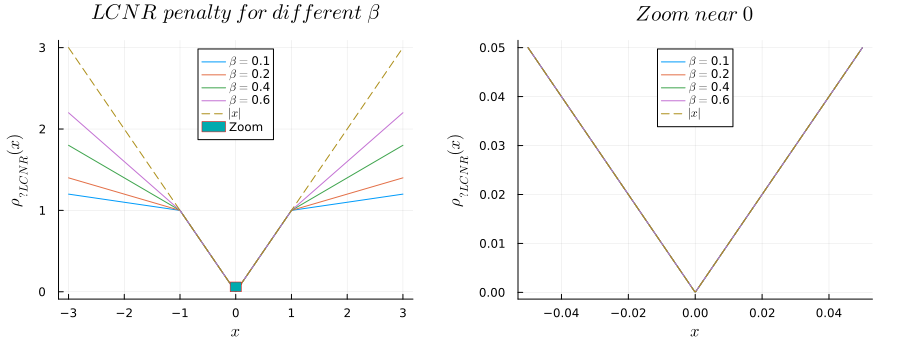

In [8]:
gr()

# LCNR penalty: α > β > 0, τ > 0
rho_lcnr(α, β, τ, x) = α * min(abs(x), τ) + β * max(abs(x) - τ, 0.0)

# parameters
α   = 1.0                 # main slope near 0 
τ   = 1.0                 # cap location
betas = [0.1, 0.2, 0.4, 0.6]  # tail slopes  each must be < α

# domains
xs_big  = range(-3.0,  3.0;  length=400)
xs_zoom = range(-0.05, 0.05; length=400)

# --- subplot 1 : wide view ---
p1 = plot(xlabel = L"x",
          ylabel = L"\rho_{\text{LCNR}}(x)",
          title  = L"LCNR\ penalty\ for\ different\ \beta",
          legend = :top, lw = 1)

for β in betas
    plot!(p1, xs_big, x -> rho_lcnr(α, β, τ, x),
          label = L"\beta=" * "$β")
end

# compare to |x| (soft reference)
plot!(p1, xs_big, x -> abs(x),
      label = L"|x|", linestyle = :dash)

# zoom rectangle
xmin, xmax = -0.1, 0.1
ymin, ymax = 0.0, 0.12
rect = Shape([xmin, xmax, xmax, xmin], [ymin, ymin, ymax, ymax])
plot!(p1, rect, fillchi = 0.0, linecolor = :red, linewidth = 0.5, label="Zoom")

# --- subplot 2 : zoom near 0 ---
p2 = plot(xlabel = L"x",
          ylabel = L"\rho_{\text{LCNR}}(x)",
          title  = L"Zoom\ near\ 0",
          legend = :top, lw = 2)

for β in betas
    plot!(p2, xs_zoom, x -> rho_lcnr(α, β, τ, x),
          label = L"\beta=" * "$β")
end
plot!(p2, xs_zoom, x -> abs(x),
      label = L"|x|", linestyle = :dash)

# --- compose ---
plot(p1, p2; layout = (1, 2), size = (900, 350), margin = 5Plots.mm)

Only the behaviour around $0$ creates the statistic $\Lambda$ so we got a facotr $\chi$ compared to `l_qut_(1,2,3)`

In [10]:
function lambda_local0(y, X, χ; verbose=false)
    r = y .- mean(y)
    if verbose
        @printf("residu norm : %.12f\n", norm(r))
    end
    return maximum(abs.(X' * r)) / (χ*norm(r))
end

function lambda_qut_lcnr(X, χ; α=0.05, M=1000, rng=Random.GLOBAL_RNG, verbose=false)
    n = size(X,1)
    λvals = Vector{Float64}(undef, M)
    for m in 1:M
        y0 = randn(rng, n)
        λvals[m] = lambda_local0(y0, X, χ; verbose=verbose)
    end
    return quantile!(λvals, 1-α)
end

lambda_qut_lcnr (generic function with 1 method)

Let $\gamma>0$. Pour $z\in\mathbb R$, note $v=|z|$, $s=\operatorname{sign}(z)$ et

$$
t_0=\gamma\chi
\qquad
t_1=\tau+\frac{\gamma}{2}(\chi+\beta)
$$


$$
\operatorname{prox}_{\gamma\psi}(z)
=
s\cdot u(v)
$$

where

$$
u(v)=
\begin{cases}
0 & \text{if } v\le t_0\\[2pt]
v-\gamma\chi & \text{if } t_0<v<t_1\\[2pt]
v-\gamma\beta & \text{if } v>t_1
\end{cases}
$$

In [47]:
function prox_lcnr(z, gamma::Real, lambda::Real, chi::Real, beta::Real, tau::Real; tie::Symbol=:right)
    @assert lambda > 0
    @assert chi > beta > 0 "need chi>beta>0"
    @assert tau > 0 && gamma > 0
    prox_lcnr_scalar(x) = begin
        v = abs(x)
        t0 = gamma*lambda*chi
        t1 = tau + gamma*lambda*(chi + beta)/2
        u = if v ≤ t0
            0.0
        elseif v < t1
            v - gamma*lambda*chi
        elseif v > t1
            v - gamma*lambda*beta
        else # v == t1
            tie === :left ? v - gamma*lambda*chi : v - gamma*lambda*beta
        end
        return sign(x) * u
    end
    return prox_lcnr_scalar.(z[1:end-1]) |> x -> vcat(x, z[end]) # keep intercept unpenalized
end

prox_lcnr (generic function with 4 methods)

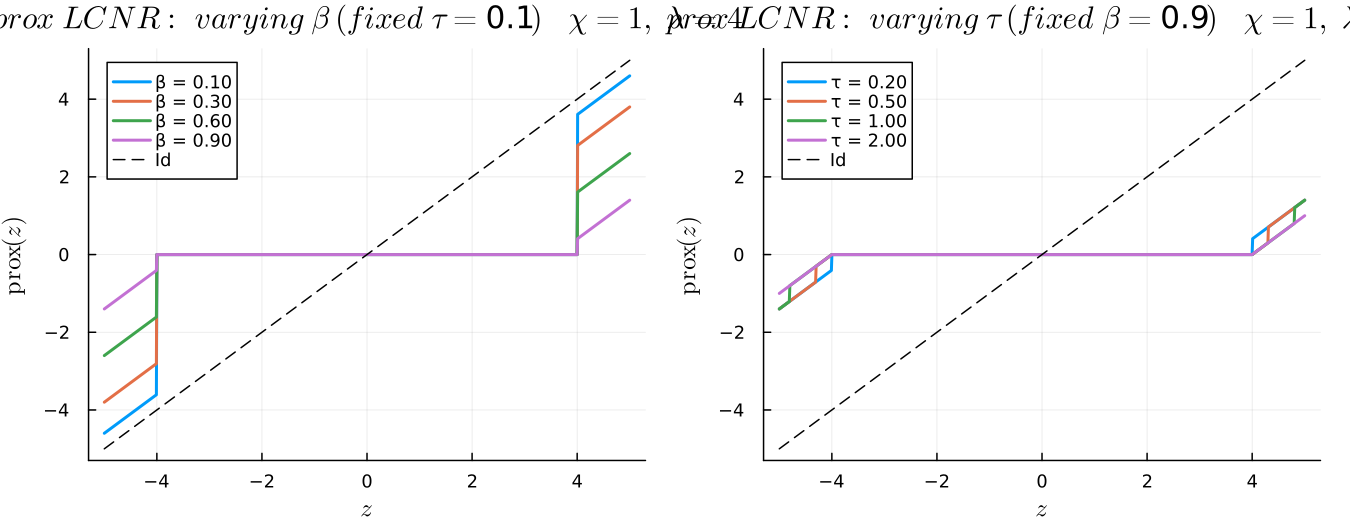

In [48]:
using Plots, LaTeXStrings, Measures, Printf
gr()
function prox_lcnr_scalar(z, γ, α, β, τ; tie::Symbol = :right)
    @assert α > β > 0 "besoin de α>β>0"
    v = abs(z)
    t0 = γ*α
    t1 = τ + γ*(α + β)/2
    u = if v ≤ t0
        0.0
    elseif v < t1
        v - γ*α
    elseif v > t1
        v - γ*β
    else # v == t1
        tie === :left ? v - γ*α : v - γ*β
    end
    return sign(z) * u
end

# Wrapper qui conserve les paramètres "modélisation" (χ, β, τ, λ)
prox_lcnr_lambda(z, γ, λ, χ, β, τ; tie=:right) =
    prox_lcnr_scalar(z, γ, λ*χ, λ*β, τ; tie=tie)

# ---------- Paramètres globaux ----------
γ = 1.0
χ = 1.0            # demandé: χ = 1
λ = 4.0            # "lambda mets-le à la valeur que tu veux" -> 4.0 ici
z_grid = range(-5, 5; length=1000)

# ---------- 1) On fait varier β (τ fixé) ----------
βs    = [0.1, 0.3, 0.6, 0.9]      # < χ pour assurer α>β
τ_fix = 0.1

pltβ = plot(
    title  = L"prox\ LCNR:\ varying\ \beta\ (fixed\ \tau= " * "$(τ_fix)" * L")\quad \chi=1,\ \lambda=4",
    xlabel = L"z", ylabel = L"\operatorname{prox}(z)",
    legend = :topleft, margin = 3mm, plot_margin = 0mm, dpi = 150
)
for β in βs
    plot!(pltβ, z_grid, z -> prox_lcnr_lambda(z, γ, λ, χ, β, τ_fix),
          label = @sprintf("β = %.2f", β), lw = 2)
end
plot!(pltβ, z_grid, z_grid; linestyle = :dash, color = :black, label = "Id")

# ---------- 2) On fait varier τ (β fixé) ----------
τs    = [0.2, 0.5, 1.0, 2.0]
β_fix = 0.9

pltτ = plot(
    title  = L"prox\ LCNR:\ varying\ \tau\ (fixed\ \beta= " * "$(β_fix)" * L")\quad \chi=1,\ \lambda=4",
    xlabel = L"z", ylabel = L"\operatorname{prox}(z)",
    legend = :topleft, margin = 3mm, plot_margin = 0mm, dpi = 150
)
for τ in τs
    plot!(pltτ, z_grid, z -> prox_lcnr_lambda(z, γ, λ, χ, β_fix, τ),
          label = @sprintf("τ = %.2f", τ), lw = 2)
end
plot!(pltτ, z_grid, z_grid; linestyle = :dash, color = :black, label = "Id")

# ---------- Composition ----------
plot(pltβ, pltτ; layout = (1, 2), size = (900, 350))


In [117]:
n, p = 70, 250
s_lst = 0:25
B_trial = 50
sigma = 0.1
α = 0.05 

χ = 1.
β = 0.1
τ = 0.1
;

In [118]:
function run_trial_lcnr(X, β_par, σ, χ, β, τ; α=0.05, tol=1e-6, max_iter=10_000, mu=1., c=0.)
    n = size(X, 1)
    X̃ = hcat(X, ones(n)) # Ajout colonne d'intercept
    y = X * β_par .+ σ * mu *randn(n) .+ c
    
    λ = lambda_qut_lcnr(X, χ; α = α, M = 1000, verbose = false)


    f(θ) = norm(y - X̃ * θ, 2)
    ∇f(θ) = X̃'*(X̃*θ-y) / norm(X̃ * θ - y, 2)
  
    L0 = 1e-4
    θ  = zeros(p + 1)

    rho_lcnr(α, β, τ, x) = α * min.(abs.(x), τ) + β * max.(abs.(x) .- τ, 0.0)


    g(θ)  = λ * sum(rho_lcnr(χ, β, τ, θ[1:end-1]))  # penalty
    prox( z,γ ) = prox_lcnr(z, γ, λ, χ, β, τ)
    θ_hat = ista(θ, f, g, ∇f, L0, prox;max_iter = 10_000,tol= tol,verbose  = false)
    return θ_hat[1:p]
end
   
function phase_transition_lcnr(n, p, s_list, χ, β, τ; σ=0.1, B=20, α=0.05, tol=1e-8, seed=42)
    m = length(s_list)
    pesr_rate = zeros(m)
    f1_rate = zeros(m)
    fdr_rate = zeros(m)
    tpr_rate = zeros(m)

    Random.seed!(42)

    for (i, s) in enumerate(s_list)
        acc_pesr = acc_f1 = acc_fdr = acc_tpr = 0.0

        for _ in 1:B
            X = randn(n, p)
            X .-= mean(X; dims=1)
            X ./= std(X;  dims=1)

            β_par = zeros(p)
            β_par[randperm(p)[1:s]] .= 3
            β_par_hat = run_trial_lcnr(X, β_par, σ, χ, β, τ; α=α, tol=tol, c=0)

            y, ŷ = abs.(β_par) .> 0, abs.(β_par_hat) .> 0

            acc_pesr += pesr(β_par, β_par_hat; tol=0)
            acc_f1 += f1score(y, ŷ)
            acc_fdr += fdr(y, ŷ)
            acc_tpr += tpr(y, ŷ)
        end

        pesr_rate[i] = acc_pesr/B
        f1_rate[i] = acc_f1 /B
        fdr_rate[i] = acc_fdr/B
        tpr_rate[i] = acc_tpr/B
    end

    return s_list, pesr_rate, f1_rate, fdr_rate, tpr_rate
end

phase_transition_lcnr (generic function with 1 method)

In [119]:
s, pesr_r, f1_r, fdr_r, tpr_r = phase_transition_lcnr(n, p, s_lst, χ, β, τ; σ=sigma, B=B_trial, tol=1e-9)

(0:25, [1.0, 0.94, 0.94, 0.9, 0.96, 0.94, 0.9, 0.8, 0.58, 0.38  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.98, 0.988, 0.9857142857142855, 0.9955555555555554, 0.9945454545454544, 0.9241758241758241, 0.882111111111111, 0.7372322318204673, 0.5539097393834235  …  0.09082008943928449, 0.09482159945317839, 0.07262961752206602, 0.0724901185770751, 0.08192358366271409, 0.05830039525691697, 0.07265016722408024, 0.03707692307692307, 0.04201025641025642, 0.04211640211640212], [0.0, 0.03, 0.02, 0.025, 0.008, 0.01, 0.002857142857142857, 0.005, 0.01622222222222222, 0.03766666666666667  …  0.021666666666666664, 0.030666666666666665, 0.034, 0.028333333333333332, 0.056666666666666664, 0.06, 0.05166666666666666, 0.03666666666666667, 0.06, 0.09666666666666668], [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9233333333333335, 0.8685714285714287, 0.6925, 0.49999999999999983  …  0.0525, 0.05411764705882351, 0.04111111111111112, 0.039999999999999994, 0.045, 0.031428571428571445, 0.03999999999999998, 0.0

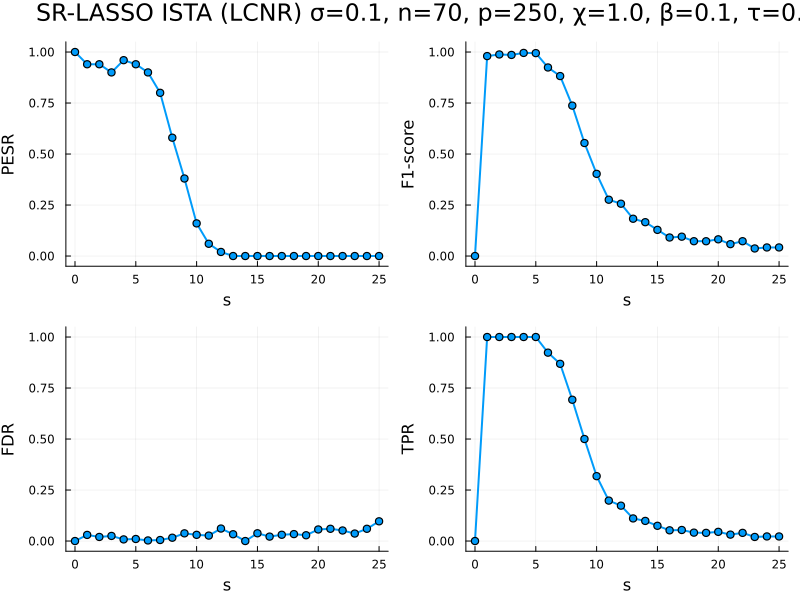

In [120]:
main_title = "SR-LASSO ISTA (LCNR) σ=$sigma, n=$n, p=$p, χ=$χ, β=$β, τ=$τ"
plot(
    plot(s, pesr_r; xlabel="s", ylabel="PESR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, f1_r; xlabel="s", ylabel="F1-score", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, fdr_r; xlabel="s", ylabel="FDR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, tpr_r; xlabel="s", ylabel="TPR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    layout =(2, 2), size = (800, 600), plot_title=main_title
)

Cool results but it's not enough to compete with $P_\nu$